In [1]:
# Importing libraries
import pandas as pd
import datetime as dt
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading data
df = pd.read_csv(r'C:\Users\MIjan\Desktop\ranbom\Ensembling\rfm_data.csv')

# Display the first few rows
df.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [3]:
# Check the data types
df.info()

# Ensuring PurchaseDate is in datetime format
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Check the data types
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


CustomerID                     int64
PurchaseDate          datetime64[ns]
TransactionAmount            float64
ProductInformation            object
OrderID                        int64
Location                      object
dtype: object

In [4]:
# checking for null
print(df.isnull().sum())
# checking for duplicates
print(df.duplicated().sum())
# checking for duplicates in main columns
print(df['CustomerID'].duplicated().sum())

CustomerID            0
PurchaseDate          0
TransactionAmount     0
ProductInformation    0
OrderID               0
Location              0
dtype: int64
0
54


In [5]:
# Checking the range of the date for frequency
df['PurchaseDate'].max(),df['PurchaseDate'].min()

(Timestamp('2023-06-10 00:00:00'), Timestamp('2023-04-11 00:00:00'))

In [6]:
# Define the reference date for recency calculation (usually the last date in your dataset)
reference_date = df['PurchaseDate'].max()

# Calculate Recency for each customer
recency_df = df.groupby('CustomerID').agg({'PurchaseDate': lambda x: (reference_date - x.max()).days}).reset_index()

# Rename column
recency_df.columns = ['CustomerID', 'Recency']

# Display the Recency table
recency_df.head()

,CustomerID,Recency
0,1011,33
1,1025,21
2,1029,0
3,1046,43
4,1049,13


In [7]:
# Calculate Frequency for each customer
frequency_df = df.groupby('CustomerID').agg({'OrderID': 'count'}).reset_index()

# Rename column
frequency_df.columns = ['CustomerID', 'Frequency']

# Display the Frequency table
frequency_df.head()


,CustomerID,Frequency
0,1011,2
1,1025,1
2,1029,1
3,1046,1
4,1049,1


In [8]:
# Calculate Monetary value for each customer
monetary_df = df.groupby('CustomerID').agg({'TransactionAmount': 'sum'}).reset_index()

# Rename column
monetary_df.columns = ['CustomerID', 'Monetary']

# Display the Monetary table
monetary_df.head()


,CustomerID,Monetary
0,1011,1129.02
1,1025,359.29
2,1029,704.99
3,1046,859.82
4,1049,225.72


In [9]:
# Merge Recency, Frequency, and Monetary dataframes
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

# Display the RFM table
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,1011,33,2,1129.02
1,1025,21,1,359.29
2,1029,0,1,704.99
3,1046,43,1,859.82
4,1049,13,1,225.72


In [10]:
# Sorting the data 
rfm_df["R_rank"] = rfm_df["Recency"].rank(ascending=False)
rfm_df["F_rank"] = rfm_df["Frequency"].rank(ascending=True)
rfm_df["M_rank"] = rfm_df["Monetary"].rank(ascending=True)

# Normalizing the rank of the customers
rfm_df["R_rank_norm"] = (rfm_df["R_rank"]/rfm_df["R_rank"].max())*100
rfm_df["F_rank_norm"] = (rfm_df["F_rank"]/rfm_df["F_rank"].max())*100
rfm_df["M_rank_norm"] = (rfm_df["M_rank"]/rfm_df["M_rank"].max())*100

rfm_df.drop(columns=['R_rank','F_rank','M_rank'],inplace=True)

print(rfm_df.head())


# Calculate the weighted RFM score
rfm_df["RFM_Score"] = 0.40 * rfm_df['R_rank_norm'] + 0.20 * rfm_df["F_rank_norm"] + 0.40 * rfm_df['M_rank_norm']

# Scale the RFM score
rfm_df["RFM_Score"] *= 0.1

# Round the RFM scores to 2 decimal places
rfm_df = rfm_df.round(2)

# Display the first 7 rows with CustomerID and RFM_Score
rfm_df[["CustomerID", 'RFM_Score']].head(7)

   CustomerID  Recency  Frequency  Monetary  R_rank_norm  F_rank_norm  \
0        1011       33          2   1129.02    47.331910    97.301587   
1        1025       21          1    359.29    64.727855    47.407407   
2        1029        0          1    704.99   100.000000    47.407407   
3        1046       43          1    859.82    27.908218    47.407407   
4        1049       13          1    225.72    78.762006    47.407407   

   M_rank_norm  
0    97.885835  
1    32.135307  
2    66.807611  
3    83.298097  
4    21.247357  


,CustomerID,RFM_Score
0,1011,7.75
1,1025,4.82
2,1029,7.62
3,1046,5.40
4,1049,4.95
5,1082,5.57
6,1086,4.71


In [11]:
# Checking the stats
rfm_df[['RFM_Score']].describe()

,RFM_Score
count,946.000000
mean,5.025581
std,1.740139
min,1.050000
25%,3.782500
50%,4.940000
75%,6.250000
max,9.770000


In [12]:
# Define customer segments based on RFM score
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >= 9,
                                      'Potential Loyalists',
                                      (np.where(
                                          rfm_df["RFM_Score"] >= 8,
                                          "At Risk",
                                          (np.where(
                                              rfm_df["RFM_Score"] >= 7,
                                              "Medium Value Customer",
                                              np.where(rfm_df["RFM_Score"] >= 4,
                                                       'Low Value Customers', 'Lost Customers')
                                          ))
                                      )))

# Display the CustomerID, RFM Score, and Customer Segment for the top 20 customers
rfm_df[['CustomerID', 'RFM_Score', "Customer_segment"]].head(20)


,CustomerID,RFM_Score,Customer_segment
0,1011,7.75,Medium Value Customer
1,1025,4.82,Low Value Customers
2,1029,7.62,Medium Value Customer
3,1046,5.40,Low Value Customers
4,1049,4.95,Low Value Customers
5,1082,5.57,Low Value Customers
6,1086,4.71,Low Value Customers
7,1104,3.31,Lost Customers
8,1108,6.57,Low Value Customers
9,1120,7.03,Medium Value Customer


In [ ]:
# Plot the number of customers in each segment as a pie chart
plt.figure(figsize=(12, 6))
segment_counts = rfm_df['Customer_segment'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segments Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

In [ ]:
#If not installed, install squarify
#pip install squarify

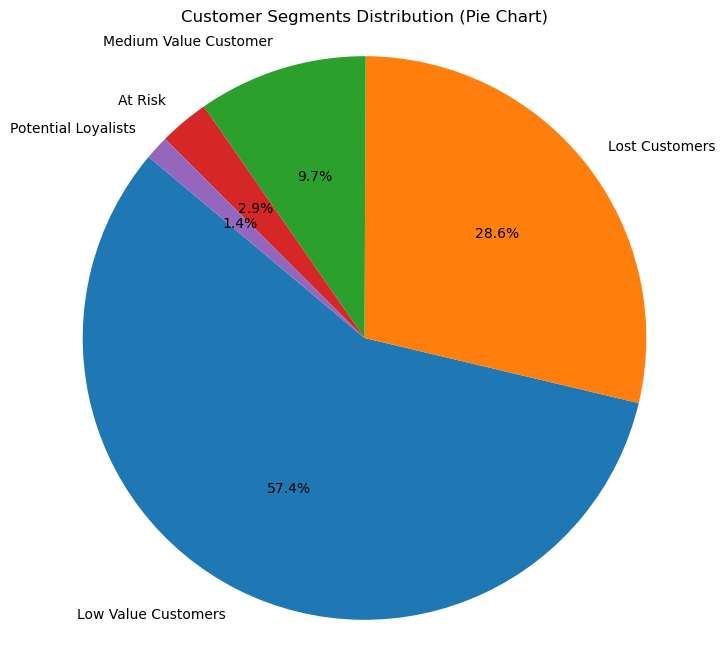

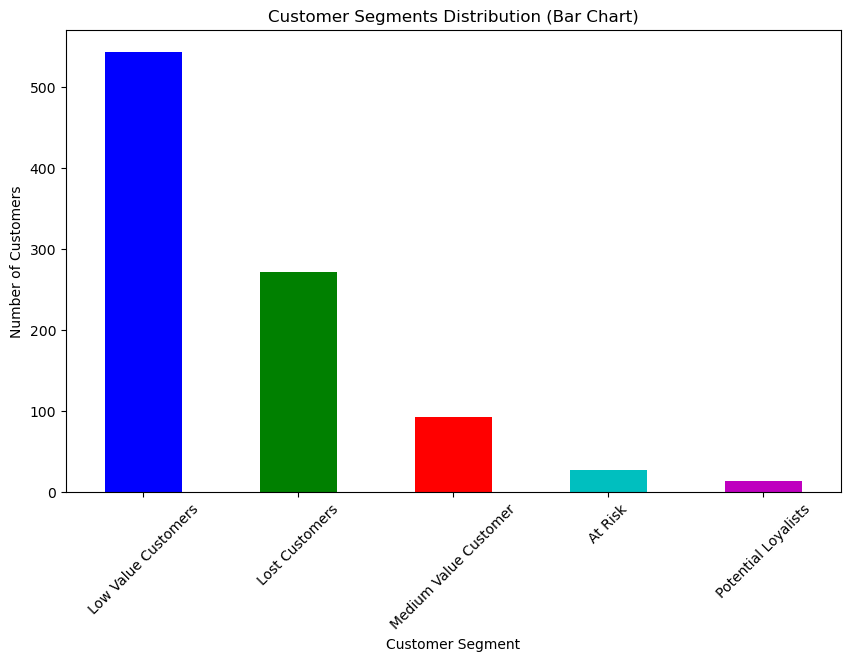

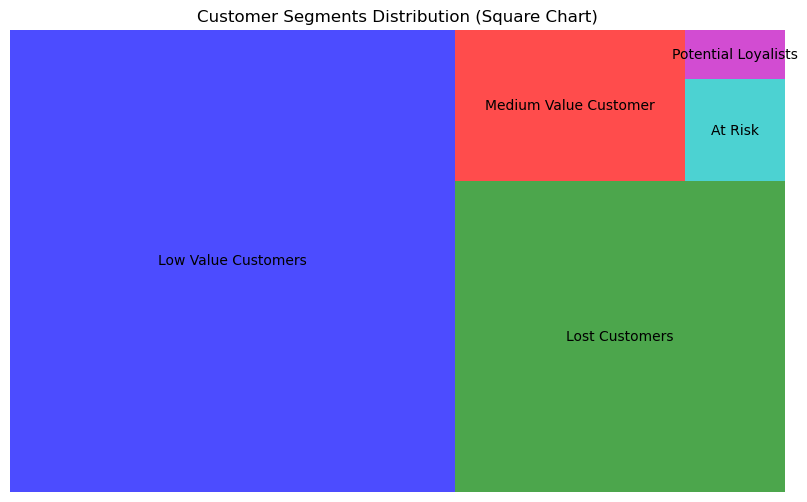

In [20]:
import squarify

# Step 1: Calculate Segment Counts
segment_counts = rfm_df['Customer_segment'].value_counts()

# Step 2: Create Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segments Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

# Step 3: Create Bar Chart
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar',color=('b','g','r','c','m'))
plt.title('Customer Segments Distribution (Bar Chart)')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# Step 4: Create Square Chart (Treemap)
plt.figure(figsize=(10, 6))
squarify.plot(sizes=segment_counts, label=segment_counts.index, alpha=0.7,color=('b','g','r','c','m'))
plt.title('Customer Segments Distribution (Square Chart)')
plt.axis('off')
plt.show()